In [1]:
# Import Libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

In [3]:
# Load Datasets
admissions = pd.read_csv('admissions.csv')
fatalities = pd.read_csv('fatalities.csv')
metrics = pd.read_csv('metrics.csv')
prescriptions = pd.read_csv('prescriptions.csv')

In [4]:
# Display dataset info
print(admissions.info())
print(fatalities.info())
print(metrics.info())
print(prescriptions.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2079 entries, 0 to 2078
Data columns (total 7 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   Year             2079 non-null   object
 1   ICD10 Code       2079 non-null   object
 2   ICD10 Diagnosis  2079 non-null   object
 3   Diagnosis Type   2079 non-null   object
 4   Metric           2079 non-null   object
 5   Sex              1386 non-null   object
 6   Value            2078 non-null   object
dtypes: object(7)
memory usage: 113.8+ KB
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1749 entries, 0 to 1748
Data columns (total 7 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   Year             1749 non-null   int64 
 1   ICD10 Code       1749 non-null   object
 2   ICD10 Diagnosis  1749 non-null   object
 3   Diagnosis Type   1749 non-null   object
 4   Metric           1749 non-null   object
 5   Sex             

In [6]:
# Quick merge using inner join to avoid large unused rows

# Convert 'Year' column to a consistent format (YYYY)
admissions['Year'] = admissions['Year'].astype(str).str[:4].astype(int)
prescriptions['Year'] = prescriptions['Year'].astype(str).str[:4].astype(int)

merged_df = pd.merge(admissions, fatalities, on='Year', how='inner')
merged_df = pd.merge(merged_df, metrics, on='Year', how='inner')
merged_df = pd.merge(merged_df, prescriptions, on='Year', how='inner')

In [7]:
print("\nMerged Dataset Info:\n", merged_df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 330561 entries, 0 to 330560
Data columns (total 29 columns):
 #   Column                                                       Non-Null Count   Dtype  
---  ------                                                       --------------   -----  
 0   Year                                                         330561 non-null  int64  
 1   ICD10 Code_x                                                 330561 non-null  object 
 2   ICD10 Diagnosis_x                                            330561 non-null  object 
 3   Diagnosis Type_x                                             330561 non-null  object 
 4   Metric_x                                                     330561 non-null  object 
 5   Sex_x                                                        220374 non-null  object 
 6   Value_x                                                      330402 non-null  object 
 7   ICD10 Code_y                                                 3305

In [8]:
# Handle Missing Values
merged_df.fillna(method='ffill', inplace=True)


/tmp/ipython-input-8-1722407042.py:2: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  merged_df.fillna(method='ffill', inplace=True)


In [9]:
# Optional: Downsample if dataset is large
if merged_df.shape[0] > 100000:
    merged_df = merged_df.sample(frac=0.2, random_state=42)  # Use 20% of the data

In [10]:
# Feature Engineering Example
if 'age' in merged_df.columns and 'age_started_smoking' in merged_df.columns:
    merged_df['tobacco_use_duration'] = merged_df['age'] - merged_df['age_started_smoking']


In [11]:
# One-hot Encoding (if needed)
categorical_cols = merged_df.select_dtypes(include=['object']).columns.tolist()
if categorical_cols:
    merged_df = pd.get_dummies(merged_df, columns=categorical_cols, drop_first=True)


In [12]:
# Quick Correlation Plot (Limit to 10 Features)
numeric_cols = merged_df.select_dtypes(include=[np.number]).columns.tolist()
if len(numeric_cols) > 10:
    numeric_cols = numeric_cols[:10]

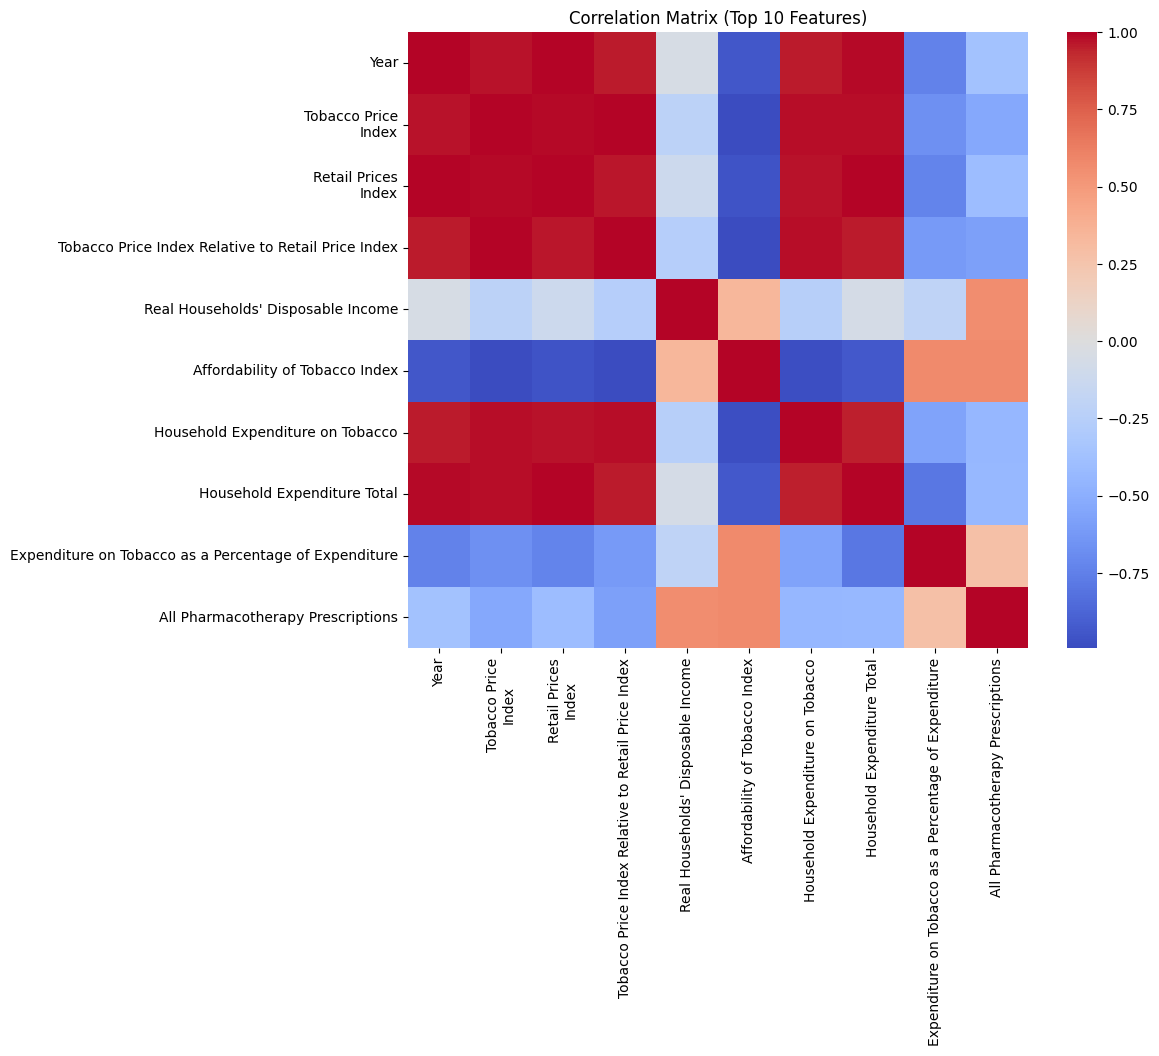

In [13]:
plt.figure(figsize=(10, 8))
sns.heatmap(merged_df[numeric_cols].corr(), annot=False, cmap='coolwarm')
plt.title('Correlation Matrix (Top 10 Features)')
plt.show()

plt.figure(figsize=(12, 10))
sns.heatmap(merged_df.corr(), annot=False, cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()


In [15]:
print("Available Columns:\n", merged_df.columns.tolist())

Available Columns:
 ['Year', 'Tobacco Price\nIndex', 'Retail Prices\nIndex', 'Tobacco Price Index Relative to Retail Price Index', "Real Households' Disposable Income", 'Affordability of Tobacco Index', 'Household Expenditure on Tobacco', 'Household Expenditure Total', 'Expenditure on Tobacco as a Percentage of Expenditure', 'All Pharmacotherapy Prescriptions', 'Nicotine Replacement Therapy (NRT) Prescriptions', 'Bupropion (Zyban) Prescriptions', 'Varenicline (Champix) Prescriptions', 'Net Ingredient Cost of All Pharmacotherapies', 'Net Ingredient Cost of Nicotine Replacement Therapies (NRT)', 'Net Ingredient Cost of Bupropion (Zyban)', 'Net Ingredient Cost of Varenicline (Champix)', 'ICD10 Code_x_C00-C14', 'ICD10 Code_x_C00-D48', 'ICD10 Code_x_C15', 'ICD10 Code_x_C16', 'ICD10 Code_x_C25', 'ICD10 Code_x_C32', 'ICD10 Code_x_C33-C34', 'ICD10 Code_x_C33-C34 & C00-C14 & C15 & C32 & C53 & C67 & C64-C66 & C68 & C16 & C25 & C80 & C92 & J40-J43 & J44 & J10-J18 & I00-I09 & I26-I51 & I20-I25 & I

In [16]:
# Define Features and Target
if 'ICD10 Diagnosis_x_All diseases which can be caused by smoking' in merged_df.columns:
    X = merged_df.drop('ICD10 Diagnosis_x_All diseases which can be caused by smoking', axis=1)
    y = merged_df['ICD10 Diagnosis_x_All diseases which can be caused by smoking']

    # Binarize target for classification
    y = (y > y.median()).astype(int)
else:
    raise ValueError("Target variable not found.")


In [17]:
# Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [18]:
# Feature Scaling
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [19]:
# Fast Model Training (Simpler Random Forest)
rf_clf = RandomForestClassifier(n_estimators=50, max_depth=5, random_state=42)
rf_clf.fit(X_train, y_train)


RandomForestClassifier(max_depth=5, n_estimators=50, random_state=42)

In [20]:
# Predictions
rf_clf_pred = rf_clf.predict(X_test)

In [21]:
# Evaluation
print("\nRandom Forest Classifier Metrics (Optimized)")
print(f"Accuracy: {accuracy_score(y_test, rf_clf_pred):.4f}")
print(f"Precision: {precision_score(y_test, rf_clf_pred):.4f}")
print(f"Recall: {recall_score(y_test, rf_clf_pred):.4f}")
print(f"F1 Score: {f1_score(y_test, rf_clf_pred):.4f}")
print(f"ROC AUC: {roc_auc_score(y_test, rf_clf_pred):.4f}")



Random Forest Classifier Metrics (Optimized)
Accuracy: 0.9835
Precision: 0.0000
Recall: 0.0000
F1 Score: 0.0000
ROC AUC: 0.5000


In [22]:
# Quick Feature Importance Plot (Top 10)
feature_importance = pd.Series(rf_clf.feature_importances_, index=X.columns).sort_values(ascending=False)


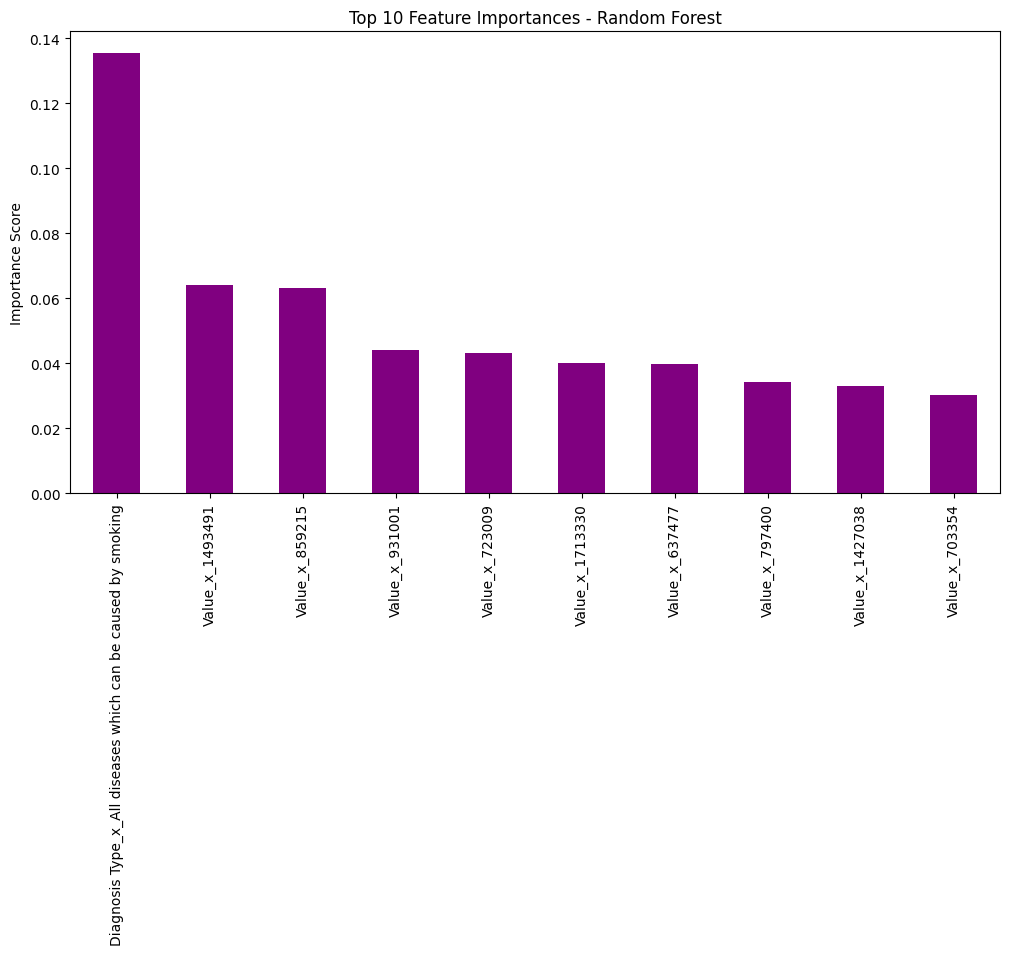

In [23]:
plt.figure(figsize=(12, 6))
feature_importance.head(10).plot(kind='bar', color='purple')
plt.title('Top 10 Feature Importances - Random Forest')
plt.ylabel('Importance Score')
plt.show()